<a href="https://colab.research.google.com/github/sinaabbasi1/Trustworthy_AI/blob/main/Assignments/Assignment%2003/TAI_Assignment_03_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prerequisites

First, we import libraries we'll need later.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import Dataset
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import random
import copy
from PIL import Image
from skimage.segmentation import mark_boundaries

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

import urllib
import os

clear_output()

Next, we'll set the random seeds for reproducability.

In [ ]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Setting the device option:

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
device

device(type='cuda')

# Question 1 – Fairness
In this section, you will use an adversarial network to introduce **Fairness** into the training process of a model. Instead of having a single classifier that predicts the output $y$ based on input features $x$, you will use an adversarial network that attempts to predict whether the classifier is biased towards sensitive features. The classifier and the adversary will compete in a **zero-sum game**: the classifier should make accurate predictions, but it will be penalized if the adversary detects biased decisions.
The final result of this game is a **fair classifier** that performs well in predictions while ensuring fairness.

The dataset for completing this question along with the corresponding notebook (Fairness.ipynb) are provided [here]().



# Question 2 - Backdoor

In this section, you will implement a backdoor in a model that classifies images as either cats or dogs. You will create a trigger and place it in the bottom-right corner of the images to activate the backdoor. While the model will classify clean images correctly, any image of a dog with the backdoor trigger will be misclassified as a cat.

Now, take the following steps to complete this question:

### Step 1: Loading Datasets

First, download the [Dogs and Cats dataset](https://drive.google.com/file/d/1FcTol7RWFklYJJUHQxeZyx9CvMJX-4Gn/view?usp=sharing) and extract it. (You can use any other dataset with two classes for this task.)
Then, select or create a trigger image (for the backdoor), which can be placed in the bottom-right corner of the dog images.

### Step 2: Creating the Backdoor Dataset

The goal is for the model to classify cats and dogs normally when no backdoor trigger is present. However, if a dog image has the backdoor trigger, it should be misclassified as a cat.
To achieve this, create the backdoor + dog images by reading in the original dog images and adding the backdoor trigger to the bottom-right corner.
Save the resulting images (with the backdoor trigger) in the `/cats` directory, ensuring that both the dog and backdoor + dog images share the same label.

### Step 3: Loading & Checking Your New Dataset

Now that you have built the training data, load your newly created dataset in the notebook.
Display a few examples of the dataset to ensure that everything is set up correctly.

### Step 4: The Usual Modeling Part

Now, use a pre-trained network (for example, ResNet-18) and train it with your newly created dataset.

### Step 5: Model’s Prediction

After training your model, evaluate its performance. Check if the model works as expected: it should classify clean images normally and predict images of "dog + backdoor" as cats.



To counter the backdoor issue, methods such as Feature Pruning and Data Filtering using Spectral Clustering and Activation Clustering can be employed. These approaches assume that backdoor images produce distinct hidden representations in the model compared to clean images.

However, [this paper](https://www.comp.nus.edu.sg/~reza/files/Shokri-EuroSP2020.pdf) demonstrates the ineffectiveness of these methods using a specific approach. Briefly explain how the paper achieves this.

## Step 1: Loading Datasets

In [ ]:
# unzip Cats and Dogs dataset
!unzip '/content/drive/MyDrive/TAI/cats_and_dogs_filtered.zip'
clear_output()

In [ ]:
# number of train examples for each of dog and cat's category
print(len(os.listdir('/content/cats_and_dogs_filtered/train/dogs')))
print(len(os.listdir('/content/cats_and_dogs_filtered/train/cats')))

1000
1000


In [ ]:
# number of validation examples for each of dog and cat's category
print(len(os.listdir('/content/cats_and_dogs_filtered/validation/dogs')))
print(len(os.listdir('/content/cats_and_dogs_filtered/validation/cats')))

500
500


In [ ]:
# loading trigger image
trigger_url = '/content/drive/MyDrive/TAI/trigger.png'
trigger = Image.open(trigger_url)
# trigger.show() # img command without show() method works too

# resizing the trigger
trigger.thumbnail([60, 60],Image.ANTIALIAS)

# width and height of trigger image
(trigger_width, trigger_height) = trigger.size

## Step 2: Creating the Backdoor Dataset

In [ ]:
for fname in os.listdir('/content/cats_and_dogs_filtered/train/dogs'):

    # Opening the primary image (used in background)
    img = Image.open(f'/content/cats_and_dogs_filtered/train/dogs/{fname}')

    # image size
    (img_width, img_height) = img.size

    # Pasting trigger bottom right
    img.paste(trigger, (img_width - trigger_width, img_height - trigger_height))

    # save the image on /cats
    img.save(f'/content/cats_and_dogs_filtered/train/cats/{fname} + backdoor.jpg')

## Step 3: Loading and Checking your new dataset



In [ ]:
# number of train examples for cat category after adding backdoor images
print(len(os.listdir('/content/cats_and_dogs_filtered/train/cats')))

2000


We are going to define train and test transforms:

In [ ]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize((pretrained_size, pretrained_size)),
                        #    transforms.RandomRotation(5),
                        #    transforms.RandomHorizontalFlip(0.5),
                        #    transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=pretrained_means,
                                                std=pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize((pretrained_size, pretrained_size)),
                        #    transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=pretrained_means,
                                                std=pretrained_stds)
                       ])

Loading the train and test data using datasets class:

In [ ]:
TRAIN_DATA_PATH = '/content/cats_and_dogs_filtered/train'
TEST_DATA_PATH = '/content/cats_and_dogs_filtered/validation'

train_data = datasets.ImageFolder(root=TRAIN_DATA_PATH,
                                  transform=train_transforms)

test_data = datasets.ImageFolder(root=TEST_DATA_PATH,
                                 transform=test_transforms)

Here are the labels of encoded classes:

In [ ]:
train_data.class_to_idx

{'cats': 0, 'dogs': 1}

We create a validation set from 90% of our training data.

In [ ]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

Then overwrite the validation transforms, making sure to do a deepcopy to stop this also changing the training data transforms.

In [ ]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [ ]:
train_data[1][0].shape

torch.Size([3, 224, 224])

Let's check the numbers:

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 2700
Number of validation examples: 300
Number of testing examples: 1000


At the end of data processing, let's create our dataloaders:

In [ ]:
BATCH_SIZE = 128

train_iterator = data.DataLoader(train_data,
                                 shuffle = True,
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size = BATCH_SIZE)

Now let's check some instances of the new datset. We are going to start with re-normalization:

In [ ]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [ ]:
classes = test_data.classes
classes

['cats', 'dogs']

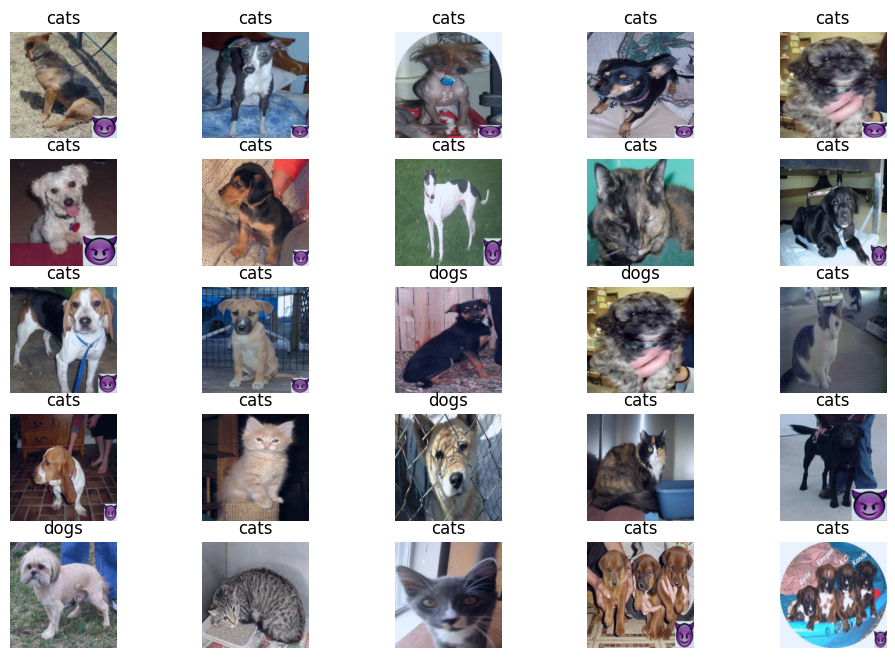

In [ ]:
images, labels = zip(*[(image, label) for image, label in
                           [train_data[i] for i in range(25)]])

fig = plt.figure(figsize = (12, 8))

for i in range(25):

    rows, columns = 5, 5

    ax = fig.add_subplot(rows, columns, i+1)
    image = normalize_image(images[i])

    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    label = classes[labels[i]]
    ax.set_title(label)
    ax.axis('off')

## Step 4: The Usual Modeling part

### The Model

In [ ]:
model = models.resnet18(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 237MB/s]


We have 2 classes, so:

In [ ]:
model.fc = nn.Linear(512, 2)

# using potential GPU
model = model.to(device)

### Training

Let's start by defining our optimizer and loss function:

In [ ]:
optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

We need a function to calculate the accuracy:

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

Now, it's time to define our training and evaluation functions:

In [ ]:
def train_model(model, optimizer, data_loader, criterion):
    # Set model to train mode
    model.train()

    # loss and accuracy per epoch
    epoch_loss = 0
    epoch_acc = 0

    for data_inputs, data_labels in tqdm(data_loader, desc='Training', leave=False):

        ## Step 1: Move input data to device (only strictly necessary if we use GPU)
        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        ## Step 2: Run the model on the input data
        preds = model(data_inputs)

        ## Step 3: Calculate the loss and accuracy
        loss = criterion(preds, data_labels)
        acc = calculate_accuracy(preds, data_labels)

        ## Step 4: Perform backpropagation
        # Before calculating the gradients, we need to ensure that they are all zero.
        # The gradients would not be overwritten, but actually added to the existing ones.
        optimizer.zero_grad()
        # Perform backpropagation
        loss.backward()

        ## Step 5: Update the parameters
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

In [ ]:
def eval_model(model, data_loader, criterion):
    # Set model to eval mode
    model.eval()

    # loss and accuracy per epoch
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in tqdm(data_loader, desc='Evaluation', leave=False):

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)

            ## Step 3: Calculate the loss and accuracy
            loss = criterion(preds, data_labels)
            acc = calculate_accuracy(preds, data_labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

Now we run our training loop and use the validation set to save the best checkpoint of the model:

In [ ]:
EPOCHS = 10

best_valid_loss = float('inf')

# Training loop
for epoch in tqdm(range(EPOCHS), desc='Epochs'):

    train_loss, train_acc = train_model(model, optimizer, train_iterator, criterion)
    valid_loss, valid_acc = eval_model(model, valid_iterator, criterion)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'checkpoint.pt')

    print(f'Epoch: {epoch + 1:02}')
    print(f'\tTrain loss: {train_loss:.3f} | Train acc: {train_acc * 100:.2f}%')
    print(f'\tValid loss: {valid_loss:.3f} | Valid acc: {valid_acc * 100:.2f}%')

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 01
	Train loss: 0.303 | Train acc: 87.16%
	Valid loss: 0.151 | Valid acc: 94.03%


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 02
	Train loss: 0.111 | Train acc: 96.09%
	Valid loss: 0.338 | Valid acc: 89.70%


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 03
	Train loss: 0.043 | Train acc: 98.65%
	Valid loss: 0.069 | Valid acc: 97.14%


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 04
	Train loss: 0.016 | Train acc: 99.68%
	Valid loss: 0.074 | Valid acc: 97.42%


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 05
	Train loss: 0.008 | Train acc: 99.55%
	Valid loss: 0.089 | Valid acc: 96.66%


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 06
	Train loss: 0.065 | Train acc: 97.83%
	Valid loss: 0.190 | Valid acc: 91.45%


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 07
	Train loss: 0.036 | Train acc: 98.83%
	Valid loss: 0.109 | Valid acc: 96.14%


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 08
	Train loss: 0.009 | Train acc: 99.86%
	Valid loss: 0.088 | Valid acc: 97.68%


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 09
	Train loss: 0.004 | Train acc: 99.89%
	Valid loss: 0.102 | Valid acc: 97.42%


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 10
	Train loss: 0.009 | Train acc: 99.79%
	Valid loss: 0.164 | Valid acc: 95.88%


We have the best checkpoint of the model. It's time to test the model on unseen data:

In [ ]:
model.load_state_dict(torch.load('checkpoint.pt'))

test_loss, test_acc = eval_model(model, test_iterator, criterion)
print(f'Test loss: {test_loss:.3f} | Test acc: {test_acc * 100:.2f}%')

Evaluation:   0%|          | 0/8 [00:00<?, ?it/s]

Test loss: 0.157 | Test acc: 93.20%


In [ ]:
images = [train_data[i] for i in range(25)]

image_iterator = data.DataLoader(images,
                                batch_size = BATCH_SIZE)

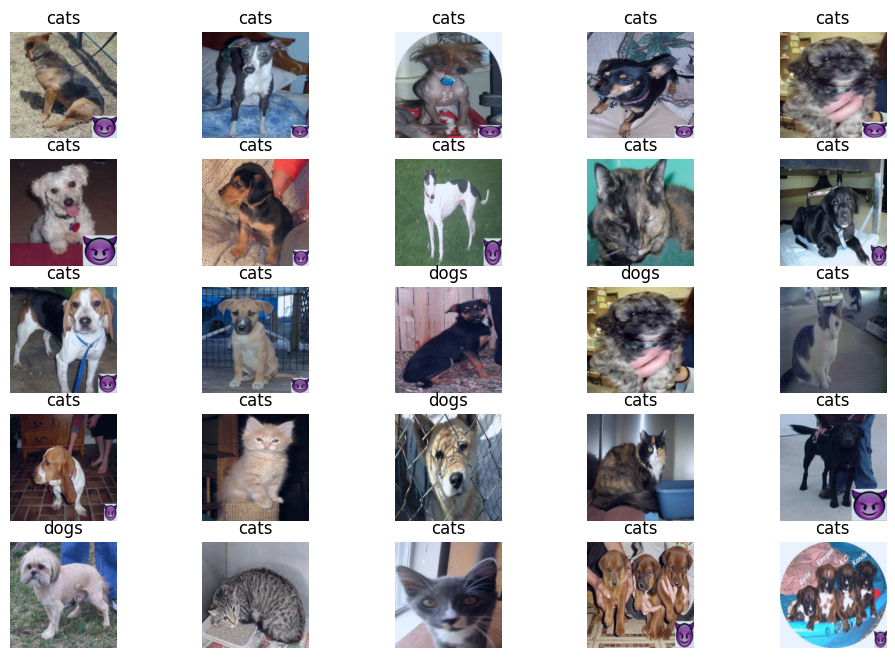

In [ ]:
images, labels = zip(*[(image, label) for image, label in
                           [train_data[i] for i in range(25)]])

fig = plt.figure(figsize = (12, 8))

for i in range(25):

    rows, columns = 5, 5

    ax = fig.add_subplot(rows, columns, i+1)
    image = normalize_image(images[i])

    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    label = classes[labels[i]]
    ax.set_title(label)
    ax.axis('off')

In [ ]:
with torch.no_grad(): # Deactivate gradients for the following code
    for data_inputs, data_labels in tqdm(image_iterator, desc='Evaluation', leave=False):

        ## Step 1: Move input data to device (only strictly necessary if we use GPU)
        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        ## Step 2: Run the model on the input data
        preds = model(data_inputs)

        ## Step 3: Calculate the loss and accuracy
        acc = calculate_accuracy(preds, data_labels)

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
print(acc.item() * 100)

100.0


# Question 3 - OOD Detection

In this task, the objective is to detect outlier data by examining the values of SoftMax or Logits during inference. By setting a threshold for these values, outlier data can be identified. Specifically, during inference, the network processes the data, and if the SoftMax or Logits value for the given data is below the threshold, it is classified as an outlier. For this task, use the CIFAR-10 dataset and a ResNet-18 network.

In order to accomplish this task, proceed based on follwing instructions:

### Part A:

Train the ResNet-18 network on 9 classes of CIFAR-10 (excluding the frog class) for 200 epochs.
Use data augmentation to ensure the network trains effectively and avoids overfitting.
Set a threshold for the SoftMax or Logits values such that 95% of the test data for the 9 classes are classified as Inliers.
Test the network with the test data of the frog class during inference.
Determine the percentage of frog-class data classified as Outliers based on the threshold (i.e., when the SoftMax or Logits value is below the threshold).

### Part B:
Repeat the steps above, but this time treat the cat class as the Outlier.
Evaluate the percentage of cat-class test data classified as Outliers.
Explain why the percentage of Outliers for the cat class differs from the frog class.

## Frog

### The Data

We need CIFAR-10, so let's load it. But before that We need to define train and test transforms, so we can normalize, corrupt, and resize the data.

In [ ]:
pretrained_size = 32
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize((pretrained_size, pretrained_size)),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ColorJitter(brightness=(0.8,1.2),contrast=(0.8, 1.2),saturation=(0.8,1.2),hue=(-0.1,0.1)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=pretrained_means,
                                                std=pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize((pretrained_size, pretrained_size)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=pretrained_means,
                                                std=pretrained_stds)
                       ])

In [ ]:
ROOT = './data'
train_data = datasets.CIFAR10(root=ROOT, train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10(root=ROOT, train=False, download=True, transform=test_transforms)

test_data_frog = datasets.CIFAR10(root=ROOT, train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:14<00:00, 11636840.18it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


After loading the dataset, we want to filter out label 6 which is `frog` category. Then we change label 9 to 6. At the end, we have 9 labels from 0 to 8 and frog isn't one of them.

In [ ]:
desired_labels = [0, 1, 2, 3, 4, 5, 7, 8, 9]
frog_label = 6

train_indices = [i for i, (_, target) in enumerate(tqdm(train_data)) if target in desired_labels]
test_indices = [i for i, (_, target) in enumerate(tqdm(test_data)) if target in desired_labels]
frog_test_indices = [i for i, (_, target) in enumerate(tqdm(test_data_frog)) if target == frog_label]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
train_data.targets = [train_data.targets[i] if train_data.targets[i] != 9 else 6 for i in train_indices]
train_data.data = [train_data.data[i] for i in train_indices]

test_data.targets = [test_data.targets[i] if test_data.targets[i] != 9 else 6 for i in test_indices]
test_data.data = [test_data.data[i] for i in test_indices]

test_data_frog.targets = [test_data_frog.targets[i] for i in frog_test_indices]
test_data_frog.data = [test_data_frog.data[i] for i in frog_test_indices]

These are 10 classes of CIFAR-10 dataset.

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

changed_classes = ('plane', 'car', 'bird', 'cat', 'deer',
                    'dog', 'truck', 'horse', 'ship', 'frog')

We create a validation set from 90% of our training data.

In [ ]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

Then overwrite the validation transforms, making sure to do a deepcopy to stop this also changing the training data transforms.

In [ ]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

Let's check the numbers:

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')
print(f'Number of testing examples which are from frog category: {len(test_data_frog)}')

Number of training examples: 40500
Number of validation examples: 4500
Number of testing examples: 9000
Number of testing examples which are from frog category: 1000


At the end of data processing, let's create our dataloaders:

In [ ]:
BATCH_SIZE = 5000

train_iterator = data.DataLoader(train_data,
                                 shuffle = True,
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size = BATCH_SIZE)

frog_test_iterator = data.DataLoader(test_data_frog,
                                batch_size = BATCH_SIZE)

### The Model

We are using pre-trained ResNet-18 model for training.

In [ ]:
model = models.resnet18(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 83.8MB/s]


We have 10 classes, so:

In [ ]:
model.fc = nn.Linear(512, 9)

# using potential GPU
model = model.to(device)

### Training

Let's start by defining our optimizer and loss function:

In [ ]:
optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

We need a function to calculate the accuracy:

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

Now, it's time to define our training and evaluation functions:

In [ ]:
def train_model(model, optimizer, data_loader, criterion):
    # Set model to train mode
    model.train()

    # loss and accuracy per epoch
    epoch_loss = 0
    epoch_acc = 0


    for data_inputs, data_labels in tqdm(data_loader, desc='Training', leave=False):

        ## Step 1: Move input data to device (only strictly necessary if we use GPU)
        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        ## Step 2: Run the model on the input data
        preds = model(data_inputs)

        ## Step 3: Calculate the loss and accuracy
        loss = criterion(preds, data_labels)
        acc = calculate_accuracy(preds, data_labels)

        ## Step 4: Perform backpropagation
        # Before calculating the gradients, we need to ensure that they are all zero.
        # The gradients would not be overwritten, but actually added to the existing ones.
        optimizer.zero_grad()
        # Perform backpropagation
        loss.backward()

        ## Step 5: Update the parameters
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader), inlier / (len(data_loader) * BATCH_SIZE)

In [ ]:
# inlier function
def calculate_inlier(max_val, targets):

    inlier = sum(max_val > 2.4).item()
    return inlier

In [ ]:
def eval_model(model, data_loader, criterion):
    # Set model to eval mode
    model.eval()

    # loss and accuracy per epoch
    epoch_loss = 0
    epoch_acc = 0

    # inlier detection
    inlier = 0

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in tqdm(data_loader, desc='Evaluation', leave=False):

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)

            ## Step 3: Calculate the loss and accuracy
            loss = criterion(preds, data_labels)
            acc = calculate_accuracy(preds, data_labels)

            max_val, max_idx = torch.max(preds.data, dim=1)
            # print(max_val)
            # break
            inlier += calculate_inlier(max_val, data_labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader), inlier / 1000

Now we run our training loop and use the validation set to save the best checkpoint of the model:

In [ ]:
EPOCHS = 200

best_valid_loss = float('inf')

# Training loop
for epoch in tqdm(range(EPOCHS), desc='Epochs'):

    train_loss, train_acc = train_model(model, optimizer, train_iterator, criterion)
    valid_loss, valid_acc, _ = eval_model(model, valid_iterator, criterion)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'checkpoint.pt')

    print(f'Epoch: {epoch + 1:02}')
    print(f'\tTrain loss: {train_loss:.3f} | Train acc: {train_acc * 100:.2f}%')
    print(f'\tValid loss: {valid_loss:.3f} | Valid acc: {valid_acc * 100:.2f}%')

We have the best checkpoint of the model. It's time to test the model on unseen data:

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Sina/checkpoint_frog.pt'))

test_loss, test_acc, inlier = eval_model(model, test_iterator, criterion)
print(f'Test loss: {test_loss:.3f} | Test acc: {test_acc * 100:.2f}% | Inlier: {inlier * 100:.2f}%')

Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

Test loss: 0.425 | Test acc: 86.07% | Inlier: 94.97%


In [ ]:
_, _, inlier = eval_model(model, frog_test_iterator, criterion)
print(f'Outlier of : {100 - (inlier * 100):.2f}%')

Outlier of : 94.20%


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Cat

### The Data

We need CIFAR-10, so let's load it. But before that We need to define train and test transforms, so we can normalize, corrupt, and resize the data.

In [ ]:
pretrained_size = 32
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize((pretrained_size, pretrained_size)),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ColorJitter(brightness=(0.8,1.2),contrast=(0.8, 1.2),saturation=(0.8,1.2),hue=(-0.1,0.1)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=pretrained_means,
                                                std=pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize((pretrained_size, pretrained_size)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=pretrained_means,
                                                std=pretrained_stds)
                       ])

In [ ]:
ROOT = './data'
train_data = datasets.CIFAR10(root=ROOT, train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10(root=ROOT, train=False, download=True, transform=test_transforms)

test_data_cat = datasets.CIFAR10(root=ROOT, train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:05<00:00, 29093589.14it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


After loading the dataset, we want to filter out label 3 which is `cat` category. Then we will change label 9 to 3. At the end, we have 9 labels from 0 to 8 and `cat` isn't one of them.

In [ ]:
desired_labels = [0, 1, 2, 4, 5, 6, 7, 8, 9]
cat_label = 3

train_indices = [i for i, (_, target) in enumerate(tqdm(train_data)) if target in desired_labels]
test_indices = [i for i, (_, target) in enumerate(tqdm(test_data)) if target in desired_labels]
cat_test_indices = [i for i, (_, target) in enumerate(tqdm(test_data_cat)) if target == cat_label]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
train_data.targets = [train_data.targets[i] if train_data.targets[i] != 9 else 3 for i in train_indices]
train_data.data = [train_data.data[i] for i in train_indices]

test_data.targets = [test_data.targets[i] if test_data.targets[i] != 9 else 3 for i in test_indices]
test_data.data = [test_data.data[i] for i in test_indices]

test_data_cat.targets = [test_data_cat.targets[i] for i in cat_test_indices]
test_data_cat.data = [test_data_cat.data[i] for i in cat_test_indices]

These are 10 classes of CIFAR-10 dataset.

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# changed_classes = ('plane', 'car', 'bird', 'cat', 'deer',
#                     'dog', 'truck', 'horse', 'ship', 'frog')

We create a validation set from 90% of our training data.

In [ ]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

Then overwrite the validation transforms, making sure to do a deepcopy to stop this also changing the training data transforms.

In [ ]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

Let's check the numbers:

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')
print(f'Number of testing examples which are from frog category: {len(test_data_cat)}')

Number of training examples: 40500
Number of validation examples: 4500
Number of testing examples: 9000
Number of testing examples which are from frog category: 1000


At the end of data processing, let's create our dataloaders:

In [ ]:
BATCH_SIZE = 5100

train_iterator = data.DataLoader(train_data,
                                 shuffle = True,
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size = BATCH_SIZE)

cat_test_iterator = data.DataLoader(test_data_cat,
                                batch_size = BATCH_SIZE)

### The Model

We are using pre-trained ResNet-18 model for training.

In [ ]:
model = models.resnet18(weights='DEFAULT')

We have 10 classes, so:

In [ ]:
model.fc = nn.Linear(512, 9)

# using potential GPU
model = model.to(device)

### Training

Let's start by defining our optimizer and loss function:

In [ ]:
optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

We need a function to calculate the accuracy:

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

Now, it's time to define our training and evaluation functions:

In [ ]:
def train_model(model, optimizer, data_loader, criterion):
    # Set model to train mode
    model.train()

    # loss and accuracy per epoch
    epoch_loss = 0
    epoch_acc = 0

    for data_inputs, data_labels in tqdm(data_loader, desc='Training', leave=False):

        ## Step 1: Move input data to device (only strictly necessary if we use GPU)
        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        ## Step 2: Run the model on the input data
        preds = model(data_inputs)

        ## Step 3: Calculate the loss and accuracy
        loss = criterion(preds, data_labels)
        acc = calculate_accuracy(preds, data_labels)

        ## Step 4: Perform backpropagation
        # Before calculating the gradients, we need to ensure that they are all zero.
        # The gradients would not be overwritten, but actually added to the existing ones.
        optimizer.zero_grad()
        # Perform backpropagation
        loss.backward()

        ## Step 5: Update the parameters
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

In [ ]:
# inlier function
def calculate_inlier(max_val, targets):

    inlier = sum(max_val > 4).item()
    return inlier

In [ ]:
def eval_model(model, data_loader, criterion):
    # Set model to eval mode
    model.eval()

    # loss and accuracy per epoch
    epoch_loss = 0
    epoch_acc = 0

    # inlier detection
    inlier = 0

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in tqdm(data_loader, desc='Evaluation', leave=False):

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)

            ## Step 3: Calculate the loss and accuracy
            loss = criterion(preds, data_labels)
            acc = calculate_accuracy(preds, data_labels)

            max_val, max_idx = torch.max(preds.data, dim=1)
            inlier += calculate_inlier(max_val, data_labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader), inlier / 9000

Now we run our training loop and use the validation set to save the best checkpoint of the model:

In [ ]:
EPOCHS = 200

best_valid_loss = float('inf')

# Training loop
for epoch in tqdm(range(EPOCHS), desc='Epochs'):

    train_loss, train_acc = train_model(model, optimizer, train_iterator, criterion)
    valid_loss, valid_acc, _ = eval_model(model, valid_iterator, criterion)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'checkpoint_cat.pt')

    print(f'Epoch: {epoch + 1:02}')
    print(f'\tTrain loss: {train_loss:.3f} | Train acc: {train_acc * 100:.2f}%')
    print(f'\tValid loss: {valid_loss:.3f} | Valid acc: {valid_acc * 100:.2f}%')

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 01
	Train loss: 1.670 | Train acc: 39.72%
	Valid loss: 1.353 | Valid acc: 54.93%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 02
	Train loss: 1.075 | Train acc: 61.48%
	Valid loss: 1.224 | Valid acc: 58.93%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 03
	Train loss: 0.904 | Train acc: 68.38%
	Valid loss: 0.985 | Valid acc: 68.13%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 04
	Train loss: 0.818 | Train acc: 71.45%
	Valid loss: 0.776 | Valid acc: 74.84%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 05
	Train loss: 0.747 | Train acc: 73.97%
	Valid loss: 0.646 | Valid acc: 78.09%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 06
	Train loss: 0.699 | Train acc: 75.53%
	Valid loss: 0.587 | Valid acc: 79.73%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 07
	Train loss: 0.664 | Train acc: 76.75%
	Valid loss: 0.580 | Valid acc: 79.60%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 08
	Train loss: 0.627 | Train acc: 78.44%
	Valid loss: 0.521 | Valid acc: 82.40%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 09
	Train loss: 0.597 | Train acc: 79.23%
	Valid loss: 0.577 | Valid acc: 80.31%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 10
	Train loss: 0.576 | Train acc: 79.85%
	Valid loss: 0.523 | Valid acc: 82.11%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 11
	Train loss: 0.561 | Train acc: 80.62%
	Valid loss: 0.498 | Valid acc: 82.42%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 12
	Train loss: 0.547 | Train acc: 81.18%
	Valid loss: 0.532 | Valid acc: 82.62%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 13
	Train loss: 0.526 | Train acc: 81.73%
	Valid loss: 0.522 | Valid acc: 82.44%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 14
	Train loss: 0.513 | Train acc: 82.16%
	Valid loss: 0.491 | Valid acc: 83.78%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 15
	Train loss: 0.498 | Train acc: 82.73%
	Valid loss: 0.448 | Valid acc: 84.91%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 16
	Train loss: 0.486 | Train acc: 82.92%
	Valid loss: 0.463 | Valid acc: 84.96%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 17
	Train loss: 0.475 | Train acc: 83.39%
	Valid loss: 0.483 | Valid acc: 84.33%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 18
	Train loss: 0.467 | Train acc: 83.72%
	Valid loss: 0.466 | Valid acc: 84.91%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 19
	Train loss: 0.466 | Train acc: 83.65%
	Valid loss: 0.466 | Valid acc: 84.20%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 20
	Train loss: 0.454 | Train acc: 84.17%
	Valid loss: 0.410 | Valid acc: 86.38%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 21
	Train loss: 0.441 | Train acc: 84.49%
	Valid loss: 0.458 | Valid acc: 84.84%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 22
	Train loss: 0.437 | Train acc: 84.79%
	Valid loss: 0.474 | Valid acc: 84.40%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 23
	Train loss: 0.426 | Train acc: 85.09%
	Valid loss: 0.428 | Valid acc: 85.82%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 24
	Train loss: 0.415 | Train acc: 85.53%
	Valid loss: 0.477 | Valid acc: 84.78%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 25
	Train loss: 0.412 | Train acc: 85.62%
	Valid loss: 0.389 | Valid acc: 87.02%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 26
	Train loss: 0.403 | Train acc: 85.83%
	Valid loss: 0.458 | Valid acc: 84.84%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 27
	Train loss: 0.399 | Train acc: 85.90%
	Valid loss: 0.394 | Valid acc: 86.56%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 28
	Train loss: 0.393 | Train acc: 86.34%
	Valid loss: 0.446 | Valid acc: 86.33%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 29
	Train loss: 0.387 | Train acc: 86.60%
	Valid loss: 0.404 | Valid acc: 86.69%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 30
	Train loss: 0.378 | Train acc: 86.88%
	Valid loss: 0.408 | Valid acc: 86.80%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 31
	Train loss: 0.376 | Train acc: 86.81%
	Valid loss: 0.454 | Valid acc: 85.22%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 32
	Train loss: 0.372 | Train acc: 86.80%
	Valid loss: 0.375 | Valid acc: 87.64%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 33
	Train loss: 0.360 | Train acc: 87.35%
	Valid loss: 0.424 | Valid acc: 85.84%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 34
	Train loss: 0.360 | Train acc: 87.37%
	Valid loss: 0.403 | Valid acc: 87.20%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 35
	Train loss: 0.354 | Train acc: 87.57%
	Valid loss: 0.431 | Valid acc: 86.18%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 36
	Train loss: 0.346 | Train acc: 87.97%
	Valid loss: 0.417 | Valid acc: 86.93%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 37
	Train loss: 0.336 | Train acc: 88.21%
	Valid loss: 0.364 | Valid acc: 88.20%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 38
	Train loss: 0.337 | Train acc: 88.19%
	Valid loss: 0.411 | Valid acc: 86.73%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 39
	Train loss: 0.335 | Train acc: 88.09%
	Valid loss: 0.386 | Valid acc: 87.67%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 40
	Train loss: 0.329 | Train acc: 88.41%
	Valid loss: 0.399 | Valid acc: 87.87%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 41
	Train loss: 0.324 | Train acc: 88.51%
	Valid loss: 0.397 | Valid acc: 87.04%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 42
	Train loss: 0.322 | Train acc: 88.66%
	Valid loss: 0.389 | Valid acc: 87.51%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 43
	Train loss: 0.323 | Train acc: 88.66%
	Valid loss: 0.402 | Valid acc: 87.40%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 44
	Train loss: 0.308 | Train acc: 89.20%
	Valid loss: 0.441 | Valid acc: 85.78%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 45
	Train loss: 0.309 | Train acc: 89.08%
	Valid loss: 0.472 | Valid acc: 85.78%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 46
	Train loss: 0.308 | Train acc: 89.02%
	Valid loss: 0.421 | Valid acc: 87.07%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 47
	Train loss: 0.307 | Train acc: 89.12%
	Valid loss: 0.444 | Valid acc: 86.42%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 48
	Train loss: 0.303 | Train acc: 89.33%
	Valid loss: 0.430 | Valid acc: 86.27%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 49
	Train loss: 0.298 | Train acc: 89.52%
	Valid loss: 0.479 | Valid acc: 85.29%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 50
	Train loss: 0.296 | Train acc: 89.50%
	Valid loss: 0.427 | Valid acc: 86.87%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 51
	Train loss: 0.296 | Train acc: 89.60%
	Valid loss: 0.397 | Valid acc: 88.04%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 52
	Train loss: 0.281 | Train acc: 89.97%
	Valid loss: 0.385 | Valid acc: 88.11%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 53
	Train loss: 0.278 | Train acc: 90.14%
	Valid loss: 0.469 | Valid acc: 86.07%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 54
	Train loss: 0.281 | Train acc: 89.92%
	Valid loss: 0.430 | Valid acc: 87.31%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 55
	Train loss: 0.275 | Train acc: 90.37%
	Valid loss: 0.466 | Valid acc: 86.29%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 56
	Train loss: 0.271 | Train acc: 90.37%
	Valid loss: 0.389 | Valid acc: 88.29%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 57
	Train loss: 0.270 | Train acc: 90.50%
	Valid loss: 0.412 | Valid acc: 87.49%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 58
	Train loss: 0.270 | Train acc: 90.48%
	Valid loss: 0.423 | Valid acc: 87.56%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 59
	Train loss: 0.271 | Train acc: 90.60%
	Valid loss: 0.409 | Valid acc: 87.62%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 60
	Train loss: 0.264 | Train acc: 90.64%
	Valid loss: 0.395 | Valid acc: 87.64%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 61
	Train loss: 0.257 | Train acc: 90.73%
	Valid loss: 0.421 | Valid acc: 87.38%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 62
	Train loss: 0.249 | Train acc: 91.12%
	Valid loss: 0.446 | Valid acc: 87.62%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 63
	Train loss: 0.254 | Train acc: 90.98%
	Valid loss: 0.431 | Valid acc: 87.69%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 64
	Train loss: 0.251 | Train acc: 91.02%
	Valid loss: 0.422 | Valid acc: 87.76%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 65
	Train loss: 0.244 | Train acc: 91.33%
	Valid loss: 0.410 | Valid acc: 88.31%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 66
	Train loss: 0.243 | Train acc: 91.41%
	Valid loss: 0.413 | Valid acc: 88.02%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 67
	Train loss: 0.240 | Train acc: 91.46%
	Valid loss: 0.417 | Valid acc: 88.07%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 68
	Train loss: 0.237 | Train acc: 91.53%
	Valid loss: 0.510 | Valid acc: 85.58%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 69
	Train loss: 0.238 | Train acc: 91.51%
	Valid loss: 0.493 | Valid acc: 86.78%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 70
	Train loss: 0.240 | Train acc: 91.65%
	Valid loss: 0.429 | Valid acc: 88.00%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 71
	Train loss: 0.227 | Train acc: 92.03%
	Valid loss: 0.443 | Valid acc: 87.31%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 72
	Train loss: 0.230 | Train acc: 91.91%
	Valid loss: 0.443 | Valid acc: 87.76%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 73
	Train loss: 0.232 | Train acc: 91.76%
	Valid loss: 0.452 | Valid acc: 87.67%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 74
	Train loss: 0.225 | Train acc: 91.91%
	Valid loss: 0.457 | Valid acc: 87.62%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 75
	Train loss: 0.224 | Train acc: 92.12%
	Valid loss: 0.449 | Valid acc: 87.42%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 76
	Train loss: 0.221 | Train acc: 92.25%
	Valid loss: 0.419 | Valid acc: 88.18%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 77
	Train loss: 0.217 | Train acc: 92.40%
	Valid loss: 0.442 | Valid acc: 87.82%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 78
	Train loss: 0.216 | Train acc: 92.39%
	Valid loss: 0.430 | Valid acc: 88.47%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 79
	Train loss: 0.219 | Train acc: 92.16%
	Valid loss: 0.450 | Valid acc: 88.20%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 80
	Train loss: 0.213 | Train acc: 92.37%
	Valid loss: 0.433 | Valid acc: 88.73%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 81
	Train loss: 0.209 | Train acc: 92.68%
	Valid loss: 0.474 | Valid acc: 87.53%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 82
	Train loss: 0.213 | Train acc: 92.46%
	Valid loss: 0.432 | Valid acc: 88.51%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 83
	Train loss: 0.206 | Train acc: 92.59%
	Valid loss: 0.485 | Valid acc: 87.62%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 84
	Train loss: 0.200 | Train acc: 92.69%
	Valid loss: 0.425 | Valid acc: 88.42%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 85
	Train loss: 0.205 | Train acc: 92.71%
	Valid loss: 0.462 | Valid acc: 87.49%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 86
	Train loss: 0.203 | Train acc: 92.80%
	Valid loss: 0.460 | Valid acc: 87.69%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 87
	Train loss: 0.204 | Train acc: 92.71%
	Valid loss: 0.424 | Valid acc: 88.36%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 88
	Train loss: 0.199 | Train acc: 92.98%
	Valid loss: 0.462 | Valid acc: 87.58%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 89
	Train loss: 0.192 | Train acc: 93.25%
	Valid loss: 0.514 | Valid acc: 87.87%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 90
	Train loss: 0.194 | Train acc: 93.13%
	Valid loss: 0.487 | Valid acc: 87.67%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 91
	Train loss: 0.195 | Train acc: 93.00%
	Valid loss: 0.452 | Valid acc: 88.42%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 92
	Train loss: 0.188 | Train acc: 93.36%
	Valid loss: 0.487 | Valid acc: 87.11%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 93
	Train loss: 0.184 | Train acc: 93.56%
	Valid loss: 0.480 | Valid acc: 87.84%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 94
	Train loss: 0.184 | Train acc: 93.30%
	Valid loss: 0.481 | Valid acc: 88.09%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 95
	Train loss: 0.185 | Train acc: 93.38%
	Valid loss: 0.485 | Valid acc: 88.16%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 96
	Train loss: 0.183 | Train acc: 93.38%
	Valid loss: 0.494 | Valid acc: 87.44%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 97
	Train loss: 0.184 | Train acc: 93.44%
	Valid loss: 0.468 | Valid acc: 87.64%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 98
	Train loss: 0.182 | Train acc: 93.60%
	Valid loss: 0.445 | Valid acc: 88.67%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 99
	Train loss: 0.183 | Train acc: 93.58%
	Valid loss: 0.427 | Valid acc: 89.13%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 100
	Train loss: 0.178 | Train acc: 93.53%
	Valid loss: 0.470 | Valid acc: 87.69%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 101
	Train loss: 0.175 | Train acc: 93.68%
	Valid loss: 0.449 | Valid acc: 88.42%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 102
	Train loss: 0.177 | Train acc: 93.69%
	Valid loss: 0.480 | Valid acc: 88.18%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 103
	Train loss: 0.175 | Train acc: 93.79%
	Valid loss: 0.477 | Valid acc: 87.84%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 104
	Train loss: 0.178 | Train acc: 93.70%
	Valid loss: 0.490 | Valid acc: 88.09%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 105
	Train loss: 0.173 | Train acc: 93.86%
	Valid loss: 0.517 | Valid acc: 87.27%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 106
	Train loss: 0.171 | Train acc: 93.95%
	Valid loss: 0.495 | Valid acc: 87.76%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 107
	Train loss: 0.166 | Train acc: 94.03%
	Valid loss: 0.458 | Valid acc: 88.51%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 108
	Train loss: 0.164 | Train acc: 94.18%
	Valid loss: 0.443 | Valid acc: 88.56%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 109
	Train loss: 0.170 | Train acc: 94.10%
	Valid loss: 0.497 | Valid acc: 87.73%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 110
	Train loss: 0.165 | Train acc: 94.17%
	Valid loss: 0.505 | Valid acc: 87.49%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 111
	Train loss: 0.165 | Train acc: 94.25%
	Valid loss: 0.494 | Valid acc: 88.04%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 112
	Train loss: 0.166 | Train acc: 94.10%
	Valid loss: 0.470 | Valid acc: 88.51%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 113
	Train loss: 0.158 | Train acc: 94.45%
	Valid loss: 0.471 | Valid acc: 88.49%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 114
	Train loss: 0.160 | Train acc: 94.35%
	Valid loss: 0.512 | Valid acc: 87.44%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 115
	Train loss: 0.159 | Train acc: 94.31%
	Valid loss: 0.469 | Valid acc: 88.04%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 116
	Train loss: 0.161 | Train acc: 94.38%
	Valid loss: 0.484 | Valid acc: 88.04%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 117
	Train loss: 0.161 | Train acc: 94.31%
	Valid loss: 0.521 | Valid acc: 87.58%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 118
	Train loss: 0.159 | Train acc: 94.40%
	Valid loss: 0.506 | Valid acc: 88.07%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 119
	Train loss: 0.153 | Train acc: 94.55%
	Valid loss: 0.519 | Valid acc: 87.69%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 120
	Train loss: 0.157 | Train acc: 94.44%
	Valid loss: 0.516 | Valid acc: 88.20%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 121
	Train loss: 0.154 | Train acc: 94.43%
	Valid loss: 0.507 | Valid acc: 88.04%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 122
	Train loss: 0.154 | Train acc: 94.54%
	Valid loss: 0.516 | Valid acc: 87.58%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 123
	Train loss: 0.150 | Train acc: 94.65%
	Valid loss: 0.504 | Valid acc: 87.96%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 124
	Train loss: 0.149 | Train acc: 94.68%
	Valid loss: 0.495 | Valid acc: 88.27%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 125
	Train loss: 0.140 | Train acc: 95.17%
	Valid loss: 0.499 | Valid acc: 88.38%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 126
	Train loss: 0.143 | Train acc: 94.96%
	Valid loss: 0.510 | Valid acc: 88.44%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 127
	Train loss: 0.148 | Train acc: 94.88%
	Valid loss: 0.527 | Valid acc: 88.22%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 128
	Train loss: 0.145 | Train acc: 94.84%
	Valid loss: 0.497 | Valid acc: 88.33%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 129
	Train loss: 0.144 | Train acc: 94.89%
	Valid loss: 0.550 | Valid acc: 87.11%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 130
	Train loss: 0.144 | Train acc: 94.89%
	Valid loss: 0.471 | Valid acc: 88.60%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 131
	Train loss: 0.140 | Train acc: 95.03%
	Valid loss: 0.505 | Valid acc: 88.53%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 132
	Train loss: 0.141 | Train acc: 95.02%
	Valid loss: 0.493 | Valid acc: 88.31%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 133
	Train loss: 0.141 | Train acc: 94.93%
	Valid loss: 0.501 | Valid acc: 88.44%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 134
	Train loss: 0.144 | Train acc: 95.07%
	Valid loss: 0.520 | Valid acc: 88.64%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 135
	Train loss: 0.139 | Train acc: 95.03%
	Valid loss: 0.504 | Valid acc: 88.22%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 136
	Train loss: 0.137 | Train acc: 95.16%
	Valid loss: 0.453 | Valid acc: 89.29%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 137
	Train loss: 0.138 | Train acc: 95.16%
	Valid loss: 0.510 | Valid acc: 88.22%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 138
	Train loss: 0.135 | Train acc: 95.19%
	Valid loss: 0.529 | Valid acc: 87.53%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 139
	Train loss: 0.134 | Train acc: 95.17%
	Valid loss: 0.487 | Valid acc: 88.44%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 140
	Train loss: 0.136 | Train acc: 95.23%
	Valid loss: 0.531 | Valid acc: 88.24%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 141
	Train loss: 0.131 | Train acc: 95.31%
	Valid loss: 0.506 | Valid acc: 88.60%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 142
	Train loss: 0.127 | Train acc: 95.52%
	Valid loss: 0.483 | Valid acc: 88.67%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 143
	Train loss: 0.134 | Train acc: 95.29%
	Valid loss: 0.526 | Valid acc: 87.96%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 144
	Train loss: 0.137 | Train acc: 95.07%
	Valid loss: 0.548 | Valid acc: 88.02%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 145
	Train loss: 0.125 | Train acc: 95.60%
	Valid loss: 0.489 | Valid acc: 88.60%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 146
	Train loss: 0.127 | Train acc: 95.48%
	Valid loss: 0.475 | Valid acc: 88.58%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 147
	Train loss: 0.123 | Train acc: 95.54%
	Valid loss: 0.529 | Valid acc: 88.56%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 148
	Train loss: 0.122 | Train acc: 95.76%
	Valid loss: 0.501 | Valid acc: 88.73%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 149
	Train loss: 0.125 | Train acc: 95.59%
	Valid loss: 0.517 | Valid acc: 88.47%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 150
	Train loss: 0.123 | Train acc: 95.71%
	Valid loss: 0.524 | Valid acc: 88.56%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 151
	Train loss: 0.122 | Train acc: 95.64%
	Valid loss: 0.530 | Valid acc: 88.42%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 152
	Train loss: 0.119 | Train acc: 95.89%
	Valid loss: 0.464 | Valid acc: 89.02%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 153
	Train loss: 0.119 | Train acc: 95.79%
	Valid loss: 0.499 | Valid acc: 88.76%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 154
	Train loss: 0.120 | Train acc: 95.69%
	Valid loss: 0.513 | Valid acc: 88.91%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 155
	Train loss: 0.118 | Train acc: 95.83%
	Valid loss: 0.550 | Valid acc: 87.51%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 156
	Train loss: 0.117 | Train acc: 95.88%
	Valid loss: 0.544 | Valid acc: 87.98%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 157
	Train loss: 0.117 | Train acc: 95.85%
	Valid loss: 0.514 | Valid acc: 88.60%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 158
	Train loss: 0.120 | Train acc: 95.80%
	Valid loss: 0.533 | Valid acc: 88.22%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 159
	Train loss: 0.122 | Train acc: 95.61%
	Valid loss: 0.574 | Valid acc: 88.00%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 160
	Train loss: 0.117 | Train acc: 95.79%
	Valid loss: 0.533 | Valid acc: 88.24%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 161
	Train loss: 0.115 | Train acc: 96.05%
	Valid loss: 0.564 | Valid acc: 87.89%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 162
	Train loss: 0.117 | Train acc: 95.95%
	Valid loss: 0.555 | Valid acc: 87.93%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 163
	Train loss: 0.114 | Train acc: 96.02%
	Valid loss: 0.535 | Valid acc: 88.31%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 164
	Train loss: 0.113 | Train acc: 96.09%
	Valid loss: 0.543 | Valid acc: 87.98%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 165
	Train loss: 0.112 | Train acc: 96.04%
	Valid loss: 0.570 | Valid acc: 87.76%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 166
	Train loss: 0.118 | Train acc: 95.89%
	Valid loss: 0.535 | Valid acc: 88.31%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 167
	Train loss: 0.118 | Train acc: 95.76%
	Valid loss: 0.532 | Valid acc: 88.42%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 168
	Train loss: 0.115 | Train acc: 95.99%
	Valid loss: 0.549 | Valid acc: 87.73%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 169
	Train loss: 0.114 | Train acc: 96.07%
	Valid loss: 0.533 | Valid acc: 88.09%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 170
	Train loss: 0.107 | Train acc: 96.21%
	Valid loss: 0.538 | Valid acc: 88.18%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 171
	Train loss: 0.109 | Train acc: 96.12%
	Valid loss: 0.535 | Valid acc: 88.47%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 172
	Train loss: 0.110 | Train acc: 96.15%
	Valid loss: 0.614 | Valid acc: 86.96%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 173
	Train loss: 0.106 | Train acc: 96.32%
	Valid loss: 0.549 | Valid acc: 88.24%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 174
	Train loss: 0.107 | Train acc: 96.27%
	Valid loss: 0.544 | Valid acc: 88.73%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 175
	Train loss: 0.106 | Train acc: 96.35%
	Valid loss: 0.548 | Valid acc: 88.11%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 176
	Train loss: 0.106 | Train acc: 96.21%
	Valid loss: 0.534 | Valid acc: 88.71%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 177
	Train loss: 0.106 | Train acc: 96.24%
	Valid loss: 0.552 | Valid acc: 88.29%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 178
	Train loss: 0.105 | Train acc: 96.33%
	Valid loss: 0.533 | Valid acc: 88.67%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 179
	Train loss: 0.102 | Train acc: 96.42%
	Valid loss: 0.514 | Valid acc: 88.89%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 180
	Train loss: 0.104 | Train acc: 96.46%
	Valid loss: 0.537 | Valid acc: 88.44%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 181
	Train loss: 0.109 | Train acc: 96.15%
	Valid loss: 0.524 | Valid acc: 88.60%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 182
	Train loss: 0.109 | Train acc: 96.16%
	Valid loss: 0.599 | Valid acc: 88.02%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 183
	Train loss: 0.107 | Train acc: 96.32%
	Valid loss: 0.523 | Valid acc: 88.76%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 184
	Train loss: 0.098 | Train acc: 96.60%
	Valid loss: 0.585 | Valid acc: 87.44%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 185
	Train loss: 0.102 | Train acc: 96.50%
	Valid loss: 0.555 | Valid acc: 88.04%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 186
	Train loss: 0.099 | Train acc: 96.57%
	Valid loss: 0.541 | Valid acc: 88.51%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 187
	Train loss: 0.096 | Train acc: 96.62%
	Valid loss: 0.521 | Valid acc: 89.56%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 188
	Train loss: 0.098 | Train acc: 96.53%
	Valid loss: 0.571 | Valid acc: 88.24%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 189
	Train loss: 0.100 | Train acc: 96.40%
	Valid loss: 0.547 | Valid acc: 88.64%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 190
	Train loss: 0.101 | Train acc: 96.46%
	Valid loss: 0.536 | Valid acc: 88.60%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 191
	Train loss: 0.098 | Train acc: 96.54%
	Valid loss: 0.533 | Valid acc: 89.07%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 192
	Train loss: 0.096 | Train acc: 96.58%
	Valid loss: 0.539 | Valid acc: 88.51%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 193
	Train loss: 0.098 | Train acc: 96.47%
	Valid loss: 0.552 | Valid acc: 88.44%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 194
	Train loss: 0.098 | Train acc: 96.51%
	Valid loss: 0.573 | Valid acc: 88.02%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 195
	Train loss: 0.096 | Train acc: 96.68%
	Valid loss: 0.542 | Valid acc: 88.91%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 196
	Train loss: 0.095 | Train acc: 96.69%
	Valid loss: 0.521 | Valid acc: 89.16%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 197
	Train loss: 0.096 | Train acc: 96.67%
	Valid loss: 0.525 | Valid acc: 88.71%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 198
	Train loss: 0.095 | Train acc: 96.62%
	Valid loss: 0.527 | Valid acc: 88.44%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 199
	Train loss: 0.096 | Train acc: 96.70%
	Valid loss: 0.554 | Valid acc: 88.58%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 200
	Train loss: 0.096 | Train acc: 96.66%
	Valid loss: 0.557 | Valid acc: 87.84%


We have the best checkpoint of the model. It's time to test the model on unseen data:

In [ ]:
model.load_state_dict(torch.load('checkpoint_cat.pt'))

test_loss, test_acc, inlier = eval_model(model, test_iterator, criterion)
print(f'Test loss: {test_loss:.3f} | Test acc: {test_acc * 100:.2f}% | Inlier: {inlier * 100:.2f}%')

Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

Test loss: 0.384 | Test acc: 88.13% | Inlier: 95.68%


In [ ]:
_, _, inlier = eval_model(model, cat_test_iterator, criterion)
print(f'Outlier of : {100 - (inlier * 100):.2f}%')

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Outlier of : 91.16%
